# Segmenting and Clustering Neighborhoods in HoChiMinh City

## Introduction

Ho Chi Minh City, also known by its former name of Saigon, is the most populous city in Vietnam with a population more than ten million in. Located in southeastern Vietnam, the metropolis surrounds the Saigon River and covers about 2,061 square kilometres.  

Ho Chi Minh City is economic heart of the nation and is classified as a Beta+ World City by Globalization and World Cities Research Network. It is home to the Ho Chi Minh City Stock Exchange, the largest stock exchange by total market capitalization in Vietnam and the headquarters of many national and international banks and companies.

As a major gateway to Vietnam, the city received over 8.6 million international visitors in 2019. Ho Chi Minh City accounted for about 22 percent of the national GDP and 29 percent its financial capital in 2018. As a result, brief information from data analysis on neighborhoods of the city can help visitors and investors to decide an interesting destination for their purpose.

## Objective

In this project, we will study in details the area classification using Foursquare data and machine learning segmentation and clustering. The aim of this project is to segment areas of Ho Chi Minh City based on the most common places captured from Foursquare. From this segmentation and clustering, a useful information about residential, tourism places, or others can be hopefully determined.

## Data acquisition and cleaning

List of Administrative Divisions of Vietnam can be obtained from the link: https://www.gso.gov.vn/dmhc2015/Default.aspx given by General Statistics Office of Vietnam. The list is saved under Excel format and can be imported as a Panda Dataframe.  

Areas (or neighborhoods) of Ho Chi Minh City is then extracted from the List of Administrative Divisions of Vietnam. As the list contains all administrative divisions of the whole Vietnam, Pandas filtering functions are therefore applied to find only Wards and Districts of Ho Chi Minh City. In addition, after examination of the extracted data, it is found that some cells containing information on Wards of Ho Chi Minh City can lead to inexact geographical determination. For example, with name of a ward as number, it should be one digit if it is less than ten, e.g. "Phường 1" instead of "Phường 01". In addition of space character also is found in some cases. As a result, a minor correction should be carried out on the filtered dataframe followed by an addition of the column named "Area" which is composed from the relevant data from the column "Wards" and "Districts". 

Text of each cell in the column "Area" is then submitted to HERE Geocoding API in order to obtain latitude and longitude of the corresponding area. The corresponding information from resulting dataframe is then submitted to Foursquare API in order to find venues for each area of Ho Chi Minh City. The resulting dataframe is then refined by grouping similar "Venue Category" items. With help of Pandas functions, the resulting data is one-hot encoded and the columns filled with 95% of zeros are then removed. Features form the output dataframe are standardized by removing the mean and scaling to unit variance with the help of sklearn library. As a result, the processed data is now ready as input for next steps of segmenting and clustering neighborhoods in Ho Chi Minh City. 


##### 1. Install and Load necessary package/library

In [1]:
#Install necessary packages
!pip install BeautifulSoup4
!pip install requests
!pip install xlrd
!pip install geocoder
!pip install googlemaps
!pip install herepy

In [2]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import re

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing

import googlemaps
import herepy

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



##### 2. Dowload List of Administrative Divisons of Vietnam from https://www.gso.gov.vn/dmhc2015/Default.aspx
##### 3. Load List of Administrative Divisions of Vietnam in to Pandas Dataframe

In [3]:
# Download List of districts of Vietnam at https://www.gso.gov.vn/dmhc2015/Default.aspx
vietnam_df = pd.read_excel('Vietnam_Administrative_Divisions.xls')

WARNING *** file size (2487130) not 512 + multiple of sector size (512)


In [4]:
vietnam_df.head()

,Tỉnh Thành Phố,Mã TP,Quận Huyện,Mã QH,Phường Xã,Mã PX,Cấp,Tên Tiếng Anh
0,Thành phố Hà Nội,1,Quận Ba Đình,1,Phường Phúc Xá,1,Phường,NaN
1,Thành phố Hà Nội,1,Quận Ba Đình,1,Phường Trúc Bạch,4,Phường,NaN
2,Thành phố Hà Nội,1,Quận Ba Đình,1,Phường Vĩnh Phúc,6,Phường,Vinh Phuc Commune
3,Thành phố Hà Nội,1,Quận Ba Đình,1,Phường Cống Vị,7,Phường,NaN
4,Thành phố Hà Nội,1,Quận Ba Đình,1,Phường Liễu Giai,8,Phường,Lieu Giai Commune


##### 4. Create dataframe of Administrative Divisions of HoChiMinh City

In [5]:
hcmc_df =  vietnam_df[vietnam_df['Tỉnh Thành Phố']=='Thành phố Hồ Chí Minh']

In [6]:
hcmc_df.head()

,Tỉnh Thành Phố,Mã TP,Quận Huyện,Mã QH,Phường Xã,Mã PX,Cấp,Tên Tiếng Anh
8826,Thành phố Hồ Chí Minh,79,Quận 1,760,Phường Tân Định,26734,Phường,NaN
8827,Thành phố Hồ Chí Minh,79,Quận 1,760,Phường Đa Kao,26737,Phường,NaN
8828,Thành phố Hồ Chí Minh,79,Quận 1,760,Phường Bến Nghé,26740,Phường,NaN
8829,Thành phố Hồ Chí Minh,79,Quận 1,760,Phường Bến Thành,26743,Phường,NaN
8830,Thành phố Hồ Chí Minh,79,Quận 1,760,Phường Nguyễn Thái Bình,26746,Phường,NaN


##### 5. Create dataframe containing only Districts and Wards of HoChiMinh City

In [7]:
hcmc_dw_df = hcmc_df[['Phường Xã','Quận Huyện']].reset_index(drop=True)
hcmc_dw_df.rename({'Phường Xã': 'Ward', 'Quận Huyện': 'District'}, axis=1, inplace=True)
hcmc_dw_df.head()

,Ward,District
0,Phường Tân Định,Quận 1
1,Phường Đa Kao,Quận 1
2,Phường Bến Nghé,Quận 1
3,Phường Bến Thành,Quận 1
4,Phường Nguyễn Thái Bình,Quận 1


In [8]:
# Check if there are formating or typing errors
for i in range(len(hcmc_dw_df)):
    print(hcmc_dw_df.iloc[i, 0] +", "+ hcmc_dw_df.iloc[i, 1])

Phường Tân Định, Quận 1
Phường Đa Kao, Quận 1
Phường Bến Nghé, Quận 1
Phường Bến Thành, Quận 1
Phường Nguyễn Thái Bình, Quận 1
Phường Phạm Ngũ Lão, Quận 1
Phường Cầu Ông Lãnh, Quận 1
Phường Cô Giang, Quận 1
Phường Nguyễn Cư Trinh, Quận 1
Phường Cầu Kho, Quận 1
Phường Thạnh Xuân, Quận 12
Phường Thạnh Lộc, Quận 12
Phường Hiệp Thành, Quận 12
Phường Thới An, Quận 12
Phường Tân Chánh Hiệp, Quận 12
Phường An Phú Đông, Quận 12
Phường Tân Thới Hiệp, Quận 12
Phường Trung Mỹ Tây, Quận 12
Phường Tân Hưng Thuận, Quận 12
Phường Đông Hưng Thuận, Quận 12
Phường Tân Thới Nhất, Quận 12
Phường Linh Xuân, Quận Thủ Đức
Phường Bình Chiểu, Quận Thủ Đức
Phường Linh Trung, Quận Thủ Đức
Phường Tam Bình, Quận Thủ Đức
Phường Tam Phú, Quận Thủ Đức
Phường Hiệp Bình Phước, Quận Thủ Đức
Phường Hiệp Bình Chánh, Quận Thủ Đức
Phường Linh Chiểu, Quận Thủ Đức
Phường Linh Tây, Quận Thủ Đức
Phường Linh Đông, Quận Thủ Đức
Phường Bình Thọ, Quận Thủ Đức
Phường Trường Thọ, Quận Thủ Đức
Phường Long Bình, Quận 9
Phường Long Thạn

In [9]:
# Repair formatting or typing errors (if exist)
for i in range(len(hcmc_dw_df)) : 
    _str = hcmc_dw_df.iloc[i, 0]
    hcmc_dw_df.iloc[i, 0] = _str.replace("Phường 0","Phường ")
hcmc_dw_df.head()

,Ward,District
0,Phường Tân Định,Quận 1
1,Phường Đa Kao,Quận 1
2,Phường Bến Nghé,Quận 1
3,Phường Bến Thành,Quận 1
4,Phường Nguyễn Thái Bình,Quận 1


In [10]:
# Add Area column to the dataframe
hcmc_dw_df['Area'] = hcmc_dw_df.Ward + ", " + hcmc_dw_df.District
hcmc_dw_df.head()

,Ward,District,Area
0,Phường Tân Định,Quận 1,"Phường Tân Định, Quận 1"
1,Phường Đa Kao,Quận 1,"Phường Đa Kao, Quận 1"
2,Phường Bến Nghé,Quận 1,"Phường Bến Nghé, Quận 1"
3,Phường Bến Thành,Quận 1,"Phường Bến Thành, Quận 1"
4,Phường Nguyễn Thái Bình,Quận 1,"Phường Nguyễn Thái Bình, Quận 1"


##### 6. Add latitude, longitude by call Google Geocode API

In [11]:
HERE_API_KEY = 'Your HEAR API Key'

In [12]:
here_maps = herepy.GeocoderApi(HERE_API_KEY)

In [13]:
hcmc_dw_df['Latitude'] = 0
hcmc_dw_df['Longitude'] = 0
for i in range(len(hcmc_dw_df)) : 
    _str = hcmc_dw_df.iloc[i, 2] + ", Hồ Chí Minh"
    geocode_result = here_maps.free_form(_str).as_dict()
    hcmc_dw_df.iloc[i, 3] = geocode_result["Response"]["View"][0]["Result"][0]["Location"]["NavigationPosition"][0]["Latitude"]
    hcmc_dw_df.iloc[i, 4] =  geocode_result["Response"]["View"][0]["Result"][0]["Location"]["NavigationPosition"][0]["Longitude"]

hcmc_dw_df.head()

,Ward,District,Area,Latitude,Longitude
0,Phường Tân Định,Quận 1,"Phường Tân Định, Quận 1",10.79266,106.69129
1,Phường Đa Kao,Quận 1,"Phường Đa Kao, Quận 1",10.78839,106.69759
2,Phường Bến Nghé,Quận 1,"Phường Bến Nghé, Quận 1",10.78133,106.70537
3,Phường Bến Thành,Quận 1,"Phường Bến Thành, Quận 1",10.77323,106.69899
4,Phường Nguyễn Thái Bình,Quận 1,"Phường Nguyễn Thái Bình, Quận 1",10.76790,106.70050


In [14]:
hcmc_dw_df.to_csv("HoChiMinhCity_Administrative_Divisions.csv", index = False)
#hcmc_dw_df = pd.read_csv("HoChiMinhCity_Administrative_Divisions.csv")

##### 7. Explore Neighborhoods in Ho Chi Minh City

In [15]:
CLIENT_ID = 'Your Foursquare API Client ID'
CLIENT_SECRET = 'Your Foursquare API Secret'
VERSION = 'Your Foursquare API Version'
LIMIT = 100
radius = 500

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
def getNearbyVenues(areas, wards, districts, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for area, ward, district, lat, lng in zip(areas, wards, districts, latitudes, longitudes):
        print(area)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        venues = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            area,
            ward,
            district,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venues])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 'Ward', 'District', 'Area Latitude', 'Area Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [18]:
#Explore nearby venues
hcmc_venues = getNearbyVenues(areas = hcmc_dw_df['Area'], wards=hcmc_dw_df['Ward'],  districts=hcmc_dw_df['District'], latitudes = hcmc_dw_df['Latitude'], longitudes = hcmc_dw_df['Longitude'])

Phường Tân Định, Quận 1
Phường Đa Kao, Quận 1
Phường Bến Nghé, Quận 1
Phường Bến Thành, Quận 1
Phường Nguyễn Thái Bình, Quận 1
Phường Phạm Ngũ Lão, Quận 1
Phường Cầu Ông Lãnh, Quận 1
Phường Cô Giang, Quận 1
Phường Nguyễn Cư Trinh, Quận 1
Phường Cầu Kho, Quận 1
Phường Thạnh Xuân, Quận 12
Phường Thạnh Lộc, Quận 12
Phường Hiệp Thành, Quận 12
Phường Thới An, Quận 12
Phường Tân Chánh Hiệp, Quận 12
Phường An Phú Đông, Quận 12
Phường Tân Thới Hiệp, Quận 12
Phường Trung Mỹ Tây, Quận 12
Phường Tân Hưng Thuận, Quận 12
Phường Đông Hưng Thuận, Quận 12
Phường Tân Thới Nhất, Quận 12
Phường Linh Xuân, Quận Thủ Đức
Phường Bình Chiểu, Quận Thủ Đức
Phường Linh Trung, Quận Thủ Đức
Phường Tam Bình, Quận Thủ Đức
Phường Tam Phú, Quận Thủ Đức
Phường Hiệp Bình Phước, Quận Thủ Đức
Phường Hiệp Bình Chánh, Quận Thủ Đức
Phường Linh Chiểu, Quận Thủ Đức
Phường Linh Tây, Quận Thủ Đức
Phường Linh Đông, Quận Thủ Đức
Phường Bình Thọ, Quận Thủ Đức
Phường Trường Thọ, Quận Thủ Đức
Phường Long Bình, Quận 9
Phường Long Thạn

In [19]:
hcmc_venues.head()

,Area,Ward,District,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Cuc Gach Quan,10.790773,106.691795,Vietnamese Restaurant
1,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Cục Gạch,10.792957,106.689020,Vietnamese Restaurant
2,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Cơm Tấm Nguyễn Phi Khanh,10.791676,106.692159,Breakfast Spot
3,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Bánh Canh Hoàng Ty,10.791867,106.691560,Vietnamese Restaurant
4,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Pho Hien,10.792811,106.693608,Breakfast Spot


In [20]:
hcmc_venues.to_csv("HoChiMinhCity_Venues.csv", index = False)
# hcmc_venues = pd.read_csv('HoChiMinhCity_Venues.csv')

In [21]:
hcmc_venues.head()

,Area,Ward,District,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Cuc Gach Quan,10.790773,106.691795,Vietnamese Restaurant
1,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Cục Gạch,10.792957,106.689020,Vietnamese Restaurant
2,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Cơm Tấm Nguyễn Phi Khanh,10.791676,106.692159,Breakfast Spot
3,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Bánh Canh Hoàng Ty,10.791867,106.691560,Vietnamese Restaurant
4,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Pho Hien,10.792811,106.693608,Breakfast Spot


In [22]:
# Refine the Venue Category
refined_hcmc_venues = hcmc_venues.copy()
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Coffee Shop', 'Venue Category'] = 'Café'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Pet Café', 'Venue Category'] = 'Café'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Cocktail Bar', 'Venue Category'] = 'Bar'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Dive Bar', 'Venue Category'] = 'Bar'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Hotel Bar', 'Venue Category'] = 'Bar'

refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Bed & Breakfast', 'Venue Category'] = 'Hotel'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Diner', 'Venue Category'] = 'Restaurant'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Comfort Food Restaurant', 'Venue Category'] = 'Restaurant'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Bistro', 'Venue Category'] = 'Restaurant'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Cafeteria', 'Venue Category'] = 'Restaurant'

refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Flea Market', 'Venue Category'] = 'Market'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Food Truck', 'Venue Category'] = 'Food'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Food & Drink Shop', 'Venue Category'] = 'Food'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Food Service', 'Venue Category'] = 'Food'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Food Court', 'Venue Category'] = 'Food'

refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Dumpling Restaurant', 'Venue Category'] = 'Chinese Restaurant'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Cantonese Restaurant', 'Venue Category'] = 'Chinese Restaurant'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Dim Sum Restaurant', 'Venue Category'] = 'Chinese Restaurant'

refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Fried Chicken Joint', 'Venue Category'] = 'Fast Food Restaurant'
refined_hcmc_venues.loc[refined_hcmc_venues['Venue Category'] == 'Burger Joint', 'Venue Category'] = 'Fast Food Restaurant'

refined_hcmc_venues.head()

,Area,Ward,District,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Cuc Gach Quan,10.790773,106.691795,Vietnamese Restaurant
1,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Cục Gạch,10.792957,106.689020,Vietnamese Restaurant
2,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Cơm Tấm Nguyễn Phi Khanh,10.791676,106.692159,Breakfast Spot
3,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Bánh Canh Hoàng Ty,10.791867,106.691560,Vietnamese Restaurant
4,"Phường Tân Định, Quận 1",Phường Tân Định,Quận 1,10.79266,106.69129,Pho Hien,10.792811,106.693608,Breakfast Spot


In [23]:
print('There are {} uniques categories.'.format(len(refined_hcmc_venues['Venue Category'].unique())))

There are 181 uniques categories.


In [24]:
# Prepare data for viewing top-twenty common venues
hcmc_venues_counted = refined_hcmc_venues.copy()
hcmc_venues_counted = hcmc_venues_counted.groupby('Venue Category').count()
hcmc_venues_counted = hcmc_venues_counted.sort_values(by=['Area'], ascending=False).head(20)
hcmc_venues_counted = hcmc_venues_counted.reset_index()
hcmc_venues_counted = hcmc_venues_counted[['Venue Category', 'Area']]
hcmc_venues_counted.head(20)

,Venue Category,Area
0,Café,572
1,Vietnamese Restaurant,452
2,Chinese Restaurant,137
3,Asian Restaurant,118
4,Seafood Restaurant,110
5,Hotel,93
6,Restaurant,71
7,Food,70
8,Market,70
9,Fast Food Restaurant,62


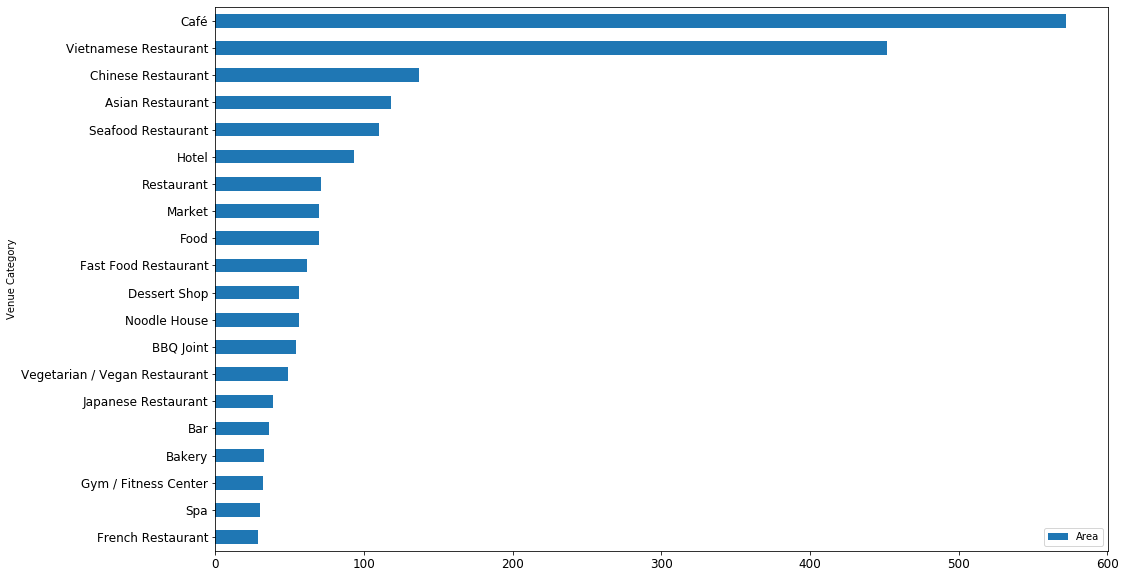

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

hcmc_venues_counted.sort_values('Area', inplace=True)
hcmc_venues_counted.plot.barh(x='Venue Category', y='Area', fontsize = 12, figsize=(16, 10))
plt.savefig("hcm_top20_venues.png")
plt.show()

In [26]:
# One-hot encoding
hcmc_venues_onehot = refined_hcmc_venues.copy()
hcmc_venues_onehot = pd.get_dummies(hcmc_venues_onehot[['Venue Category']], prefix="", prefix_sep="")

# Add Area, Ward, District columns back to dataframe
hcmc_venues_onehot['Area'] = refined_hcmc_venues['Area']

# Move Area column to the first column
fixed_columns = [hcmc_venues_onehot.columns[-1]] + list(hcmc_venues_onehot.columns[:-1])
hcmc_venues_onehot = hcmc_venues_onehot[fixed_columns]

hcmc_venues_grouped = hcmc_venues_onehot.groupby('Area').sum().reset_index()
print(hcmc_venues_grouped.shape)
hcmc_venues_grouped.head()

(276, 182)


,Area,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Stadium,Bathing Area,Beach,Beer Bar,Beer Garden,Bike Rental / Bike Share,Boarding House,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Bus Station,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Campground,Chinese Restaurant,Clothing Store,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Eastern European Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Football Stadium,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,German Restaurant,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Lounge,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Nightclub,Noodle House,North Indian Restaurant,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Russian Restaurant,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Taxi,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Track,Track Stadium,Travel Agency,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Volleyball Court,Water Park,Whisky Bar,Women's Store,Yoga Studio
0,"Phường 1, Quận 10",0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,"Phường 1, Quận 11",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,"Phường 1, Quận 3",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,1,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0
3,"Phường 1, Quận 4",0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [27]:
hcmc_venues_grouped.to_csv("HoChiMinhCity_Venues_Encoded.csv", index = False)

In [28]:
# Remove columns whose number of zeros are more than 5%
hcmc_venues_grouped_trimmed = hcmc_venues_grouped.drop(columns = ["Area"])
hcmc_venues_grouped_trimmed = hcmc_venues_grouped_trimmed.loc[:, (hcmc_venues_grouped == 1).sum() > 0.05 * len(hcmc_venues_grouped)]

# Add Area column back to dataframe
hcmc_venues_grouped_trimmed['Area'] = hcmc_venues_grouped['Area']

# Move Area column to the first column
fixed_columns = [hcmc_venues_grouped_trimmed.columns[-1]]  + list(hcmc_venues_grouped_trimmed.columns[:-1])
hcmc_venues_grouped_trimmed = hcmc_venues_grouped_trimmed[fixed_columns]

hcmc_venues_grouped = hcmc_venues_grouped_trimmed
print(hcmc_venues_grouped.shape)
hcmc_venues_grouped.head()

(276, 34)


,Area,Asian Restaurant,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Café,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Ice Cream Shop,Japanese Restaurant,Karaoke Bar,Korean Restaurant,Market,Multiplex,Noodle House,Park,Pizza Place,Restaurant,Seafood Restaurant,Snack Place,Spa,Steakhouse,Supermarket,Sushi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Phường 1, Quận 10",0,1,0,0,0,0,4,0,0,1,0,1,0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1
1,"Phường 1, Quận 11",0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,"Phường 1, Quận 3",0,0,1,0,0,0,2,1,0,2,0,3,0,0,1,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,3
3,"Phường 1, Quận 4",2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,"Phường 1, Quận 5",1,0,0,0,0,0,5,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1


In [29]:
# Print each Area along with the top 5 most common venues
num_top_venues = 5
for area in hcmc_venues_grouped['Area']:
    print("----"+area+"----")
    temp = hcmc_venues_grouped[hcmc_venues_grouped['Area'] == area].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Phường 1, Quận 10----
               venue  freq
0               Café   4.0
1       Noodle House   2.0
2          BBQ Joint   1.0
3  Hotpot Restaurant   1.0
4              Hotel   1.0


----Phường 1, Quận 11----
                           venue  freq
0                   Dessert Shop   1.0
1  Vegetarian / Vegan Restaurant   1.0
2                           Food   1.0
3               Asian Restaurant   0.0
4                      Multiplex   0.0


----Phường 1, Quận 3----
                   venue  freq
0  Vietnamese Restaurant   3.0
1                   Food   3.0
2           Noodle House   2.0
3           Dessert Shop   2.0
4                   Café   2.0


----Phường 1, Quận 4----
                   venue  freq
0       Asian Restaurant   2.0
1                   Café   1.0
2      Convenience Store   1.0
3  Vietnamese Restaurant   1.0
4              Bookstore   0.0


----Phường 1, Quận 5----
                venue  freq
0                Café   5.0
1  Chinese Restaurant   2.0
2    Asian Re

In [30]:
# Get Top20 most visited venues for each Area 
num_top_venues = 20
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hcmc_venues_sorted = pd.DataFrame(columns=columns)
hcmc_venues_sorted['Area'] = hcmc_venues_grouped['Area']

for ind in np.arange(hcmc_venues_grouped.shape[0]):
    hcmc_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hcmc_venues_grouped.iloc[ind, :], num_top_venues)
    
hcmc_venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,"Phường 1, Quận 10",Café,Noodle House,Vietnamese Restaurant,Hotel,Food,Dessert Shop,Hotpot Restaurant,BBQ Joint,Breakfast Spot,Ice Cream Shop,Convenience Store,Bookstore,Bar,Fast Food Restaurant,Bakery,Gym / Fitness Center,Chinese Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
1,"Phường 1, Quận 11",Vegetarian / Vegan Restaurant,Food,Dessert Shop,Convenience Store,Hotpot Restaurant,Hotel,Gym / Fitness Center,Fast Food Restaurant,Vietnamese Restaurant,Ice Cream Shop,Café,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Chinese Restaurant,Japanese Restaurant,Karaoke Bar,Korean Restaurant
2,"Phường 1, Quận 3",Vietnamese Restaurant,Food,Café,Noodle House,Dessert Shop,Market,Hotpot Restaurant,Chinese Restaurant,Bakery,Breakfast Spot,Convenience Store,Bookstore,Bar,Fast Food Restaurant,BBQ Joint,Gym / Fitness Center,Hotel,Japanese Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant
3,"Phường 1, Quận 4",Asian Restaurant,Convenience Store,Café,Vietnamese Restaurant,Steakhouse,Hotel,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Supermarket,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotpot Restaurant,Spa
4,"Phường 1, Quận 5",Café,Chinese Restaurant,Vietnamese Restaurant,Seafood Restaurant,Karaoke Bar,Noodle House,Asian Restaurant,Snack Place,Restaurant,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Supermarket,Convenience Store,Dessert Shop,Fast Food Restaurant,Food


In [31]:
# Normalize data
hcmc_venues_normalized = hcmc_venues_grouped.copy()
hcmc_venues_normalized = hcmc_venues_normalized.drop(columns = ["Area"])
temp_df = preprocessing.StandardScaler().fit(hcmc_venues_normalized).transform(hcmc_venues_normalized)
hcmc_venues_normalized = pd.DataFrame(temp_df, columns=hcmc_venues_normalized.columns, index=hcmc_venues_normalized.index)

# Add Area column back to dataframe
hcmc_venues_normalized['Area'] = hcmc_venues_grouped['Area']

# Move Area column to the first column
fixed_columns = [hcmc_venues_normalized.columns[-1]]  + list(hcmc_venues_normalized.columns[:-1])
hcmc_venues_normalized = hcmc_venues_normalized[fixed_columns]

hcmc_venues_normalized.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


,Area,Asian Restaurant,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Café,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Ice Cream Shop,Japanese Restaurant,Karaoke Bar,Korean Restaurant,Market,Multiplex,Noodle House,Park,Pizza Place,Restaurant,Seafood Restaurant,Snack Place,Spa,Steakhouse,Supermarket,Sushi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Phường 1, Quận 10",-0.545479,1.733317,-0.272709,-0.217452,-0.256715,-0.25351,0.636072,-0.341533,-0.248069,1.493320,-0.397665,1.319971,-0.319744,0.524144,4.171331,-0.248069,-0.260052,-0.231160,-0.280722,-0.525677,-0.23116,3.284264,-0.23116,-0.28379,-0.458887,-0.429046,-0.294963,-0.224431,-0.239732,-0.280762,-0.239732,-0.317493,-0.238942
1,"Phường 1, Quận 11",-0.545479,-0.421618,-0.272709,-0.217452,-0.256715,-0.25351,-0.683897,-0.341533,-0.248069,1.493320,-0.397665,1.319971,-0.319744,-0.266369,-0.239732,-0.248069,-0.260052,-0.231160,-0.280722,-0.525677,-0.23116,-0.370804,-0.23116,-0.28379,-0.458887,-0.429046,-0.294963,-0.224431,-0.239732,-0.280762,-0.239732,1.470835,-0.613646
2,"Phường 1, Quận 3",-0.545479,-0.421618,2.008127,-0.217452,-0.256715,-0.25351,-0.023912,0.346519,-0.248069,3.366757,-0.397665,4.856979,-0.319744,-0.266369,4.171331,-0.248069,-0.260052,-0.231160,-0.280722,1.546993,-0.23116,3.284264,-0.23116,-0.28379,-0.458887,-0.429046,-0.294963,-0.224431,-0.239732,-0.280762,-0.239732,-0.317493,0.510466
3,"Phường 1, Quận 4",2.006251,-0.421618,-0.272709,-0.217452,-0.256715,-0.25351,-0.353905,-0.341533,4.031129,-0.380118,-0.397665,-0.448534,-0.319744,-0.266369,-0.239732,-0.248069,-0.260052,-0.231160,-0.280722,-0.525677,-0.23116,-0.370804,-0.23116,-0.28379,-0.458887,-0.429046,-0.294963,-0.224431,-0.239732,-0.280762,-0.239732,-0.317493,-0.238942
4,"Phường 1, Quận 5",0.730386,-0.421618,-0.272709,-0.217452,-0.256715,-0.25351,0.966065,1.034572,-0.248069,-0.380118,-0.397665,-0.448534,-0.319744,-0.266369,-0.239732,-0.248069,-0.260052,4.326001,-0.280722,-0.525677,-0.23116,1.456730,-0.23116,-0.28379,-0.458887,0.647470,-0.294963,-0.224431,-0.239732,-0.280762,-0.239732,-0.317493,-0.238942


## Methodolody

K-mean clustering, an unsupervised machine learning algorithm is used in this project to cluster the venues based on the list of locations for different types of visiting purposes such as Vietnamese restaurants, Chinese restaurants, bars, sports, café, foods and beverages, etc. The resulting output would give a better understanding of similarities and dissimilarities between the chosen areas (or neighborhoods) to retrieve more insights and to conclude which ares wins over others.  

Silhoutte score is applied to determine the optimal number of clusters for K-mean algorithm. Labels obtained from the clustering result, with the optimum value of number of clusters, is then assigned to each area by the help of Pandas merge functions.  

Map with circled markers representing corresponding area locations is then shown to visualize the resulting clusters. Each cluster is then extracted from the clustering dataframe and a horizontal bar-chart is shown to get a closer insight to the most common venues of each cluster, hopefully yielding some useful information.

##### 1. Cluster Areas

###### Silhouette Analysis method is used to find the optimal cluster number for the Kmean algorithm

In [32]:
hcmc_venues_grouped_clustering = hcmc_venues_normalized.copy()
hcmc_venues_grouped_clustering = hcmc_venues_grouped_clustering.drop('Area', 1)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = range(2, 20)
scores = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=0).fit(hcmc_venues_grouped_clustering)
    preds = clusterer.fit_predict(hcmc_venues_grouped_clustering)
    centers = clusterer.cluster_centers_

    score = silhouette_score(hcmc_venues_grouped_clustering, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    scores.append(score)

#scores = abs(np.array(scores))
print("The best core {} obtained at K = {}".format(min(scores), np.argmin(scores) + 2))

For n_clusters = 2, silhouette score is 0.5348846846321665)
For n_clusters = 3, silhouette score is 0.39199334807463476)
For n_clusters = 4, silhouette score is 0.31160239618381586)
For n_clusters = 5, silhouette score is 0.328944548292392)
For n_clusters = 6, silhouette score is 0.325005649081719)
For n_clusters = 7, silhouette score is 0.297543523597433)
For n_clusters = 8, silhouette score is 0.310877847456975)
For n_clusters = 9, silhouette score is 0.27813459519415584)
For n_clusters = 10, silhouette score is 0.30480623182850713)
For n_clusters = 11, silhouette score is 0.25310434092568806)
For n_clusters = 12, silhouette score is 0.29052750779891384)
For n_clusters = 13, silhouette score is 0.28405355663329596)
For n_clusters = 14, silhouette score is 0.13313791840190603)
For n_clusters = 15, silhouette score is 0.17025868220000026)
For n_clusters = 16, silhouette score is 0.1458628123781812)
For n_clusters = 17, silhouette score is 0.29850509958159016)
For n_clusters = 18, silho

###### Run k-means to cluster the Areas

In [33]:
from sklearn.cluster import KMeans
kclusters = np.argmin(scores) + 2

hcmc_venues_grouped_clustering = hcmc_venues_normalized.drop('Area', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hcmc_venues_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_
print(len(kmeans.labels_))
print(hcmc_venues_grouped.shape)

276
(276, 34)


###### Create a new dataframe that includes the cluster as well as the top 20 venues for each Area.

In [34]:
hcmc_venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,"Phường 1, Quận 10",Café,Noodle House,Vietnamese Restaurant,Hotel,Food,Dessert Shop,Hotpot Restaurant,BBQ Joint,Breakfast Spot,Ice Cream Shop,Convenience Store,Bookstore,Bar,Fast Food Restaurant,Bakery,Gym / Fitness Center,Chinese Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
1,"Phường 1, Quận 11",Vegetarian / Vegan Restaurant,Food,Dessert Shop,Convenience Store,Hotpot Restaurant,Hotel,Gym / Fitness Center,Fast Food Restaurant,Vietnamese Restaurant,Ice Cream Shop,Café,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Chinese Restaurant,Japanese Restaurant,Karaoke Bar,Korean Restaurant
2,"Phường 1, Quận 3",Vietnamese Restaurant,Food,Café,Noodle House,Dessert Shop,Market,Hotpot Restaurant,Chinese Restaurant,Bakery,Breakfast Spot,Convenience Store,Bookstore,Bar,Fast Food Restaurant,BBQ Joint,Gym / Fitness Center,Hotel,Japanese Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant
3,"Phường 1, Quận 4",Asian Restaurant,Convenience Store,Café,Vietnamese Restaurant,Steakhouse,Hotel,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Supermarket,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotpot Restaurant,Spa
4,"Phường 1, Quận 5",Café,Chinese Restaurant,Vietnamese Restaurant,Seafood Restaurant,Karaoke Bar,Noodle House,Asian Restaurant,Snack Place,Restaurant,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Supermarket,Convenience Store,Dessert Shop,Fast Food Restaurant,Food


In [35]:
hcmc_dw_df.head()

,Ward,District,Area,Latitude,Longitude
0,Phường Tân Định,Quận 1,"Phường Tân Định, Quận 1",10.79266,106.69129
1,Phường Đa Kao,Quận 1,"Phường Đa Kao, Quận 1",10.78839,106.69759
2,Phường Bến Nghé,Quận 1,"Phường Bến Nghé, Quận 1",10.78133,106.70537
3,Phường Bến Thành,Quận 1,"Phường Bến Thành, Quận 1",10.77323,106.69899
4,Phường Nguyễn Thái Bình,Quận 1,"Phường Nguyễn Thái Bình, Quận 1",10.76790,106.70050


In [36]:
# Add clustering labels
hcmc_grouped_clustering = hcmc_venues_grouped.drop('Area', 1)
hcmc_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hcmc_venues_merged = hcmc_dw_df.copy()

# Merge hcmc_venues_grouped with hcmc_dw_df to add latitude/longitude for each Area
hcmc_venues_merged = hcmc_venues_merged.join(hcmc_venues_sorted.set_index('Area'), on='Area')

hcmc_venues_merged = hcmc_venues_merged[hcmc_venues_merged['Cluster Labels'].notnull()]
hcmc_venues_merged.head()

,Ward,District,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Phường Tân Định,Quận 1,"Phường Tân Định, Quận 1",10.79266,106.69129,8.0,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Breakfast Spot,Asian Restaurant,Spa,Food,Bar,Market,Korean Restaurant,Karaoke Bar,Snack Place,BBQ Joint,Bakery,Bookstore,Sushi Restaurant,Supermarket,Chinese Restaurant,Convenience Store,Dessert Shop
1,Phường Đa Kao,Quận 1,"Phường Đa Kao, Quận 1",10.78839,106.69759,11.0,Vietnamese Restaurant,Café,Japanese Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Breakfast Spot,BBQ Joint,Restaurant,Bakery,Fast Food Restaurant,Sushi Restaurant,Gym / Fitness Center,Hotel,Steakhouse,Ice Cream Shop,Asian Restaurant,Chinese Restaurant,Bar,Noodle House,Park
2,Phường Bến Nghé,Quận 1,"Phường Bến Nghé, Quận 1",10.78133,106.70537,7.0,Bar,Hotel,Café,Spa,Vietnamese Restaurant,Restaurant,Noodle House,BBQ Joint,Convenience Store,Dessert Shop,Gym / Fitness Center,Asian Restaurant,Steakhouse,Pizza Place,Multiplex,Seafood Restaurant,Sushi Restaurant,Bakery,Supermarket,Bookstore
3,Phường Bến Thành,Quận 1,"Phường Bến Thành, Quận 1",10.77323,106.69899,1.0,Vietnamese Restaurant,Café,Hotel,Spa,Asian Restaurant,Restaurant,Bar,Fast Food Restaurant,Japanese Restaurant,BBQ Joint,Pizza Place,Dessert Shop,Food,Ice Cream Shop,Bakery,Sushi Restaurant,Steakhouse,Multiplex,Noodle House,Seafood Restaurant
4,Phường Nguyễn Thái Bình,Quận 1,"Phường Nguyễn Thái Bình, Quận 1",10.76790,106.70050,10.0,Vietnamese Restaurant,Bar,Restaurant,BBQ Joint,Café,Fast Food Restaurant,Hotel,Ice Cream Shop,Market,Dessert Shop,Food,Japanese Restaurant,Spa,Multiplex,Sushi Restaurant,Bakery,Supermarket,Bookstore,Breakfast Spot,Steakhouse


##### 2. Visualize the resulting clusters

In [37]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [38]:
_str = "Thành Phố Hồ Chí Minh"
geocode_result = here_maps.free_form(_str).as_dict()
hcmc_latitude = geocode_result["Response"]["View"][0]["Result"][0]["Location"]["NavigationPosition"][0]["Latitude"]
hcmc_longitude =  geocode_result["Response"]["View"][0]["Result"][0]["Location"]["NavigationPosition"][0]["Longitude"]

#hcmc_map = folium.Map(location=[hcmc_latitude, hcmc_longitude], zoom_start=12)
#hcmc_map

In [39]:
# create map
map_clusters = folium.Map(location=[hcmc_latitude, hcmc_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hcmc_venues_merged['Latitude'], hcmc_venues_merged['Longitude'], hcmc_venues_merged['Area'], hcmc_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#5a3bfd', '#3176f8', '#09a9ee', '#1dd1e2', '#44eed2', '#6dfdbf', '#92fda9', '#bbee91', '#e2d176', '#ffa95b', '#ff763d', '#ff3b1e', '#ff0000']


##### 3. Examine Clusters

In [40]:
def plot_top_most_common_venues(data, top_number):
    extracted_data = data.copy()
    extracted_data = extracted_data.groupby('1st Most Common Venue').count()
    extracted_data = extracted_data.sort_values(by=['Area'], ascending=False).head(top_number)
    extracted_data = extracted_data.reset_index()
    extracted_data = extracted_data[['1st Most Common Venue', 'Area']]
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    extracted_data.sort_values('Area', inplace=True)
    extracted_data.plot.barh(x='1st Most Common Venue', y='Area', fontsize = 12, figsize=(16, 10))
    #plt.savefig("hcm_venues.png")
    plt.show()

In [41]:
def show_cluster_inf(data, cluster_index, top_number):
    cluster_df = hcmc_venues_merged.loc[hcmc_venues_merged['Cluster Labels'] == cluster_index, hcmc_venues_merged.columns[[2] + list(range(5, hcmc_venues_merged.shape[1]))], ]
    print("Number of Area in the cluster: {}".format(len(cluster_df)))
    plot_top_most_common_venues(cluster_df, top_number)
    
    return cluster_df

###### Cluster 1

Number of Area in the cluster: 17


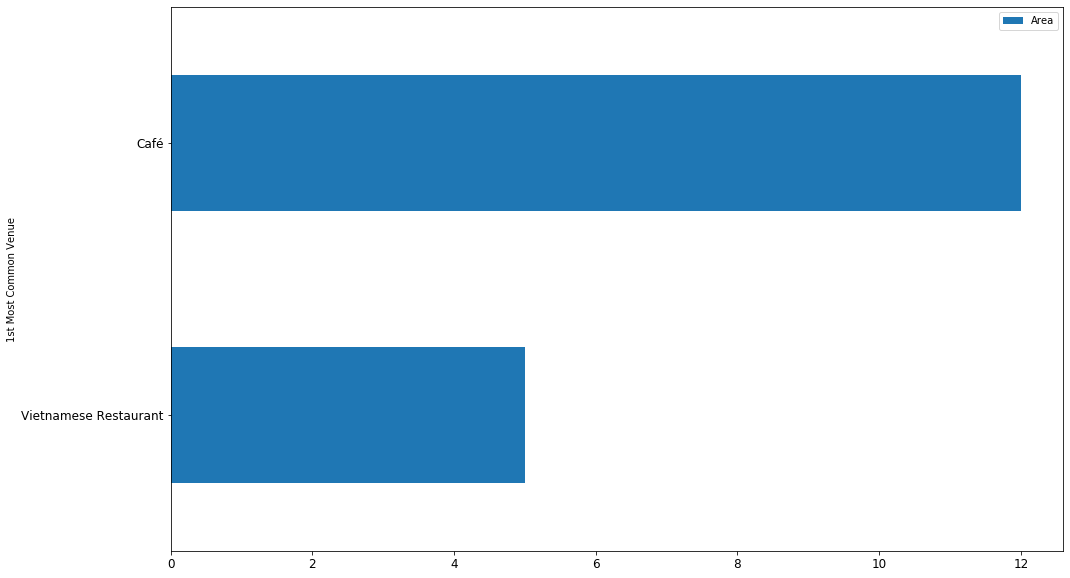

In [42]:
cluster_1 = show_cluster_inf(hcmc_venues_merged, 0, 5)

In [43]:
cluster_1

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
7,"Phường Cô Giang, Quận 1",0.0,Vietnamese Restaurant,Hotel,Seafood Restaurant,Food,Vegetarian / Vegan Restaurant,Restaurant,Japanese Restaurant,Steakhouse,Spa,Snack Place,Sushi Restaurant,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Café,Chinese Restaurant,Convenience Store,Dessert Shop
86,"Phường 1, Quận Tân Bình",0.0,Café,Vietnamese Restaurant,Hotel,Gym / Fitness Center,Noodle House,Park,Ice Cream Shop,Breakfast Spot,Chinese Restaurant,Hotpot Restaurant,Bookstore,Bar,Dessert Shop,Fast Food Restaurant,Food,Bakery,BBQ Joint,Convenience Store,Japanese Restaurant,Vegetarian / Vegan Restaurant
87,"Phường 3, Quận Tân Bình",0.0,Café,Vietnamese Restaurant,Hotel,Market,Noodle House,Ice Cream Shop,BBQ Joint,Breakfast Spot,Bookstore,Chinese Restaurant,Hotpot Restaurant,Dessert Shop,Bar,Fast Food Restaurant,Bakery,Food,Gym / Fitness Center,Convenience Store,Japanese Restaurant,Vegetarian / Vegan Restaurant
113,"Phường 1, Quận Phú Nhuận",0.0,Café,Vietnamese Restaurant,Restaurant,BBQ Joint,Bookstore,Gym / Fitness Center,Pizza Place,Asian Restaurant,Seafood Restaurant,Food,Sushi Restaurant,Bakery,Bar,Supermarket,Breakfast Spot,Steakhouse,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant
115,"Phường 8, Quận Phú Nhuận",0.0,Café,Hotel,Chinese Restaurant,Vietnamese Restaurant,Bar,Breakfast Spot,Gym / Fitness Center,Japanese Restaurant,Asian Restaurant,Food,BBQ Joint,Bakery,Sushi Restaurant,Bookstore,Supermarket,Steakhouse,Spa,Convenience Store,Dessert Shop,Fast Food Restaurant
116,"Phường 15, Quận Phú Nhuận",0.0,Café,Vietnamese Restaurant,Hotel,BBQ Joint,Bookstore,Chinese Restaurant,Asian Restaurant,Sushi Restaurant,Spa,Seafood Restaurant,Restaurant,Bakery,Bar,Supermarket,Breakfast Spot,Steakhouse,Convenience Store,Dessert Shop,Fast Food Restaurant,Food
117,"Phường 10, Quận Phú Nhuận",0.0,Café,Vietnamese Restaurant,Chinese Restaurant,Noodle House,Bar,Breakfast Spot,Gym / Fitness Center,Hotel,Japanese Restaurant,Pizza Place,Park,BBQ Joint,Bakery,Sushi Restaurant,Bookstore,Supermarket,Steakhouse,Spa,Convenience Store,Dessert Shop
118,"Phường 11, Quận Phú Nhuận",0.0,Café,Vietnamese Restaurant,Chinese Restaurant,Hotel,BBQ Joint,Bakery,Bar,Breakfast Spot,Japanese Restaurant,Asian Restaurant,Park,Sushi Restaurant,Supermarket,Steakhouse,Bookstore,Spa,Snack Place,Seafood Restaurant,Convenience Store,Dessert Shop
119,"Phường 17, Quận Phú Nhuận",0.0,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ice Cream Shop,Bakery,Spa,Seafood Restaurant,Bookstore,Dessert Shop,Food,Fast Food Restaurant,Breakfast Spot,Convenience Store,Chinese Restaurant,Hotel,Bar,BBQ Joint,Gym / Fitness Center,Japanese Restaurant
120,"Phường 14, Quận Phú Nhuận",0.0,Vietnamese Restaurant,Café,Steakhouse,Gym / Fitness Center,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Ice Cream Shop,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar


###### Cluster 2

Number of Area in the cluster: 2


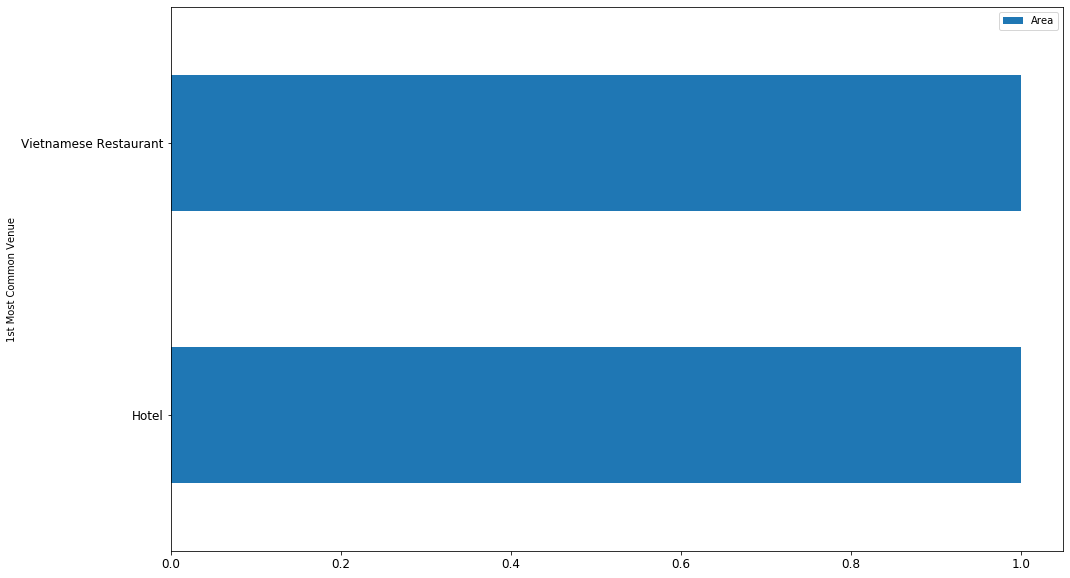

In [44]:
cluster_2 = show_cluster_inf(hcmc_venues_merged, 1, 5)

In [45]:
cluster_2

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
3,"Phường Bến Thành, Quận 1",1.0,Vietnamese Restaurant,Café,Hotel,Spa,Asian Restaurant,Restaurant,Bar,Fast Food Restaurant,Japanese Restaurant,BBQ Joint,Pizza Place,Dessert Shop,Food,Ice Cream Shop,Bakery,Sushi Restaurant,Steakhouse,Multiplex,Noodle House,Seafood Restaurant
5,"Phường Phạm Ngũ Lão, Quận 1",1.0,Hotel,Vietnamese Restaurant,Café,Restaurant,Bar,Japanese Restaurant,Spa,Asian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Food,Fast Food Restaurant,Pizza Place,BBQ Joint,Bakery,Sushi Restaurant,Chinese Restaurant,Bookstore,Breakfast Spot,Supermarket


###### Cluster 3

Number of Area in the cluster: 1


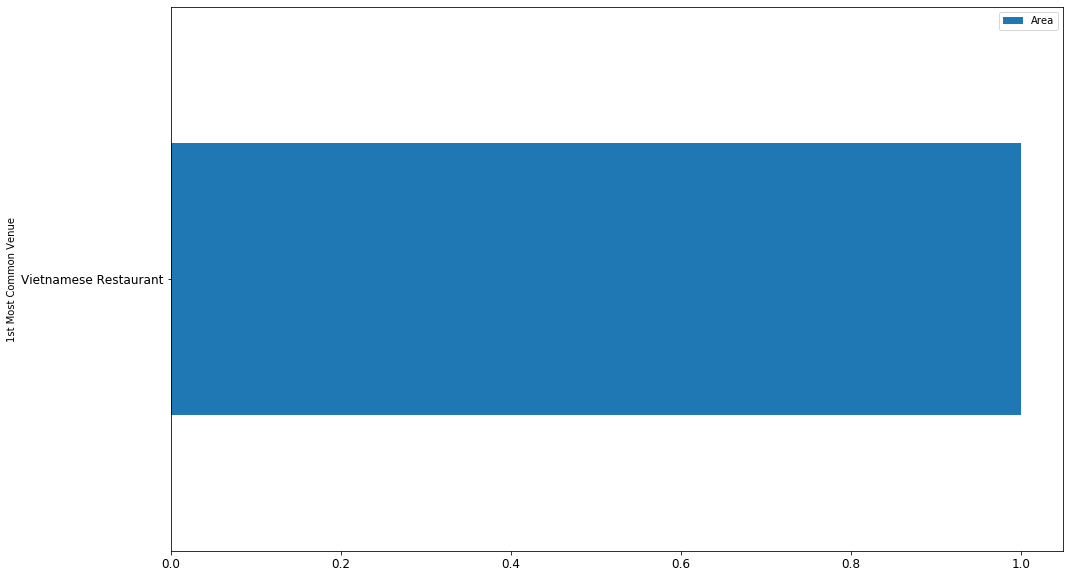

In [46]:
cluster_3 = show_cluster_inf(hcmc_venues_merged, 2, 5)

In [47]:
cluster_3

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
146,"Phường 2, Quận 3",2.0,Vietnamese Restaurant,Café,Bakery,Bookstore,Food,Noodle House,Pizza Place,Dessert Shop,Hotel,Japanese Restaurant,Asian Restaurant,Hotpot Restaurant,Sushi Restaurant,Bar,Chinese Restaurant,Convenience Store,Restaurant,Seafood Restaurant,Snack Place,Vegetarian / Vegan Restaurant


###### Cluster 4

Number of Area in the cluster: 3


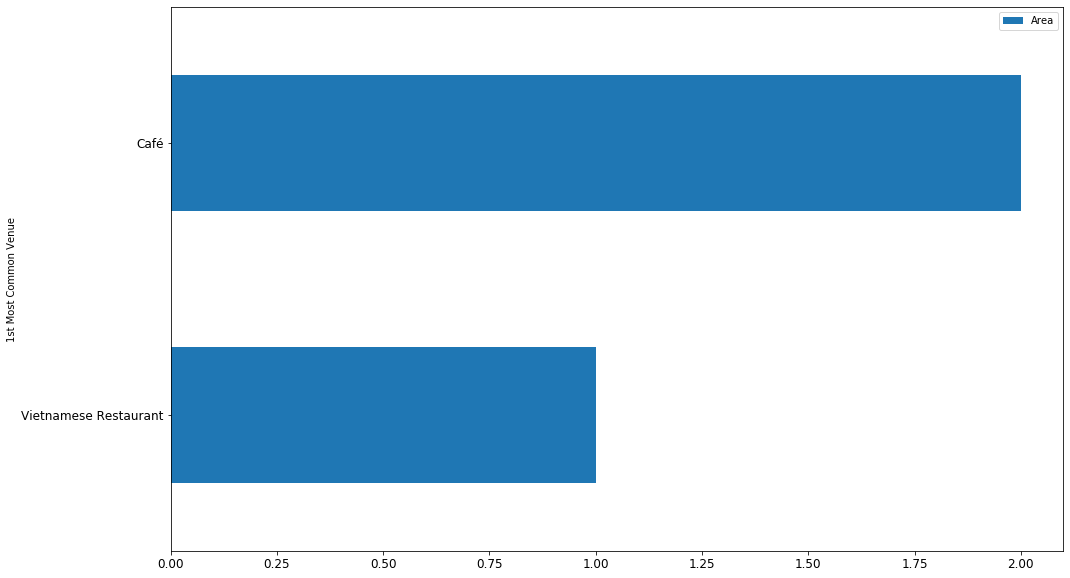

In [48]:
cluster_4 = show_cluster_inf(hcmc_venues_merged, 3, 5)

In [49]:
cluster_4

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
134,"Phường 8, Quận 3",3.0,Café,Vietnamese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Bar,Noodle House,Market,Korean Restaurant,Food,Hotel,Ice Cream Shop,Karaoke Bar,Dessert Shop,Bookstore,Bakery,Restaurant,Snack Place,Convenience Store,Breakfast Spot
140,"Phường 6, Quận 3",3.0,Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Bakery,Hotel,Hotpot Restaurant,Snack Place,BBQ Joint,Pizza Place,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Gym / Fitness Center,Bar,Bookstore,Convenience Store,Dessert Shop,Fast Food Restaurant,Food
144,"Phường 5, Quận 3",3.0,Vietnamese Restaurant,Café,Snack Place,Bakery,Hotel,Vegetarian / Vegan Restaurant,Asian Restaurant,Seafood Restaurant,Market,BBQ Joint,Supermarket,Chinese Restaurant,Food,Gym / Fitness Center,Pizza Place,Noodle House,Korean Restaurant,Convenience Store,Sushi Restaurant,Bar


###### Cluster 5

Number of Area in the cluster: 32


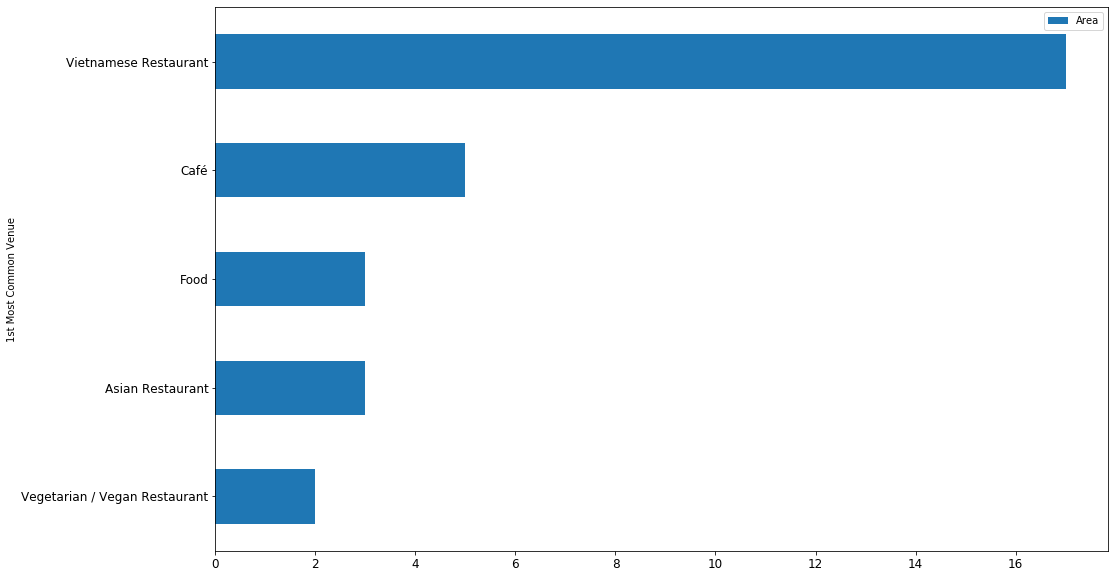

In [50]:
cluster_5 = show_cluster_inf(hcmc_venues_merged, 4, 5)

In [51]:
cluster_5

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
14,"Phường Tân Chánh Hiệp, Quận 12",4.0,Vietnamese Restaurant,Café,Food,Ice Cream Shop,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant
19,"Phường Đông Hưng Thuận, Quận 12",4.0,Café,Vietnamese Restaurant,Food,Restaurant,Bar,Bookstore,Breakfast Spot,Bakery,Ice Cream Shop,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,BBQ Joint,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
35,"Phường Tân Phú, Quận 9",4.0,Vietnamese Restaurant,Food,Ice Cream Shop,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Café,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant
46,"Phường 15, Quận Gò Vấp",4.0,Vietnamese Restaurant,Food,Asian Restaurant,Supermarket,Steakhouse,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Café,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Sushi Restaurant,Gym / Fitness Center,Hotel,Hotpot Restaurant,Ice Cream Shop
56,"Phường 4, Quận Gò Vấp",4.0,Vietnamese Restaurant,Bookstore,Food,Ice Cream Shop,BBQ Joint,Bakery,Bar,Breakfast Spot,Café,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant
66,"Phường 12, Quận Bình Thạnh",4.0,Vietnamese Restaurant,Food,Noodle House,Café,Convenience Store,Hotel,Gym / Fitness Center,Fast Food Restaurant,Dessert Shop,Chinese Restaurant,Ice Cream Shop,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
68,"Phường 5, Quận Bình Thạnh",4.0,Vietnamese Restaurant,Café,Food,Asian Restaurant,Steakhouse,Hotel,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Supermarket,Gym / Fitness Center,Hotpot Restaurant,Spa
71,"Phường 6, Quận Bình Thạnh",4.0,Vegetarian / Vegan Restaurant,Convenience Store,Food,Hotpot Restaurant,Hotel,Gym / Fitness Center,Fast Food Restaurant,Dessert Shop,Vietnamese Restaurant,Ice Cream Shop,Café,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Chinese Restaurant,Japanese Restaurant,Karaoke Bar,Korean Restaurant
90,"Phường 5, Quận Tân Bình",4.0,Food,Vietnamese Restaurant,Hotel,Café,Park,Convenience Store,Gym / Fitness Center,Fast Food Restaurant,Dessert Shop,Chinese Restaurant,Ice Cream Shop,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
101,"Phường Tân Thành, Quận Tân Phú",4.0,Vietnamese Restaurant,Snack Place,Food,Café,Bar,Bookstore,Bakery,Breakfast Spot,Ice Cream Shop,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,BBQ Joint,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar


###### Cluster 6

Number of Area in the cluster: 153


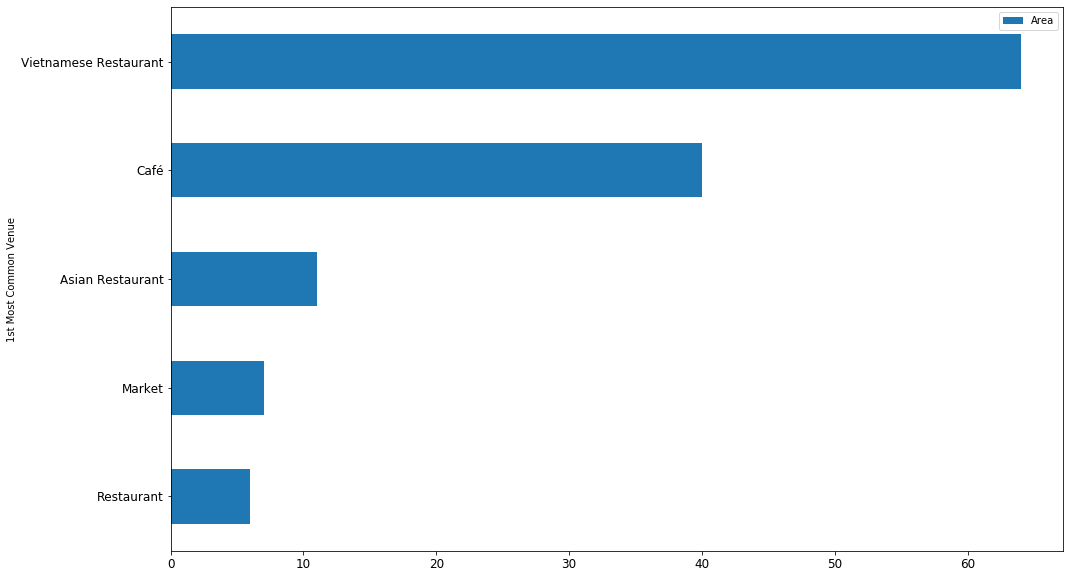

In [52]:
cluster_6 = show_cluster_inf(hcmc_venues_merged, 5, 5)

In [53]:
cluster_6

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
10,"Phường Thạnh Xuân, Quận 12",5.0,Vietnamese Restaurant,Noodle House,Café,Convenience Store,Hotel,Gym / Fitness Center,Food,Fast Food Restaurant,Dessert Shop,Chinese Restaurant,Ice Cream Shop,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
11,"Phường Thạnh Lộc, Quận 12",5.0,Café,Vietnamese Restaurant,Ice Cream Shop,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant
13,"Phường Thới An, Quận 12",5.0,Vietnamese Restaurant,Café,Restaurant,Bakery,Bar,Bookstore,Breakfast Spot,BBQ Joint,Ice Cream Shop,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
15,"Phường An Phú Đông, Quận 12",5.0,Vietnamese Restaurant,Ice Cream Shop,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Café,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant
16,"Phường Tân Thới Hiệp, Quận 12",5.0,Café,Vietnamese Restaurant,Ice Cream Shop,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant
17,"Phường Trung Mỹ Tây, Quận 12",5.0,Café,Vietnamese Restaurant,Ice Cream Shop,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant
18,"Phường Tân Hưng Thuận, Quận 12",5.0,Convenience Store,Café,Park,Vietnamese Restaurant,Hotel,Gym / Fitness Center,Food,Fast Food Restaurant,Dessert Shop,Chinese Restaurant,Ice Cream Shop,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
20,"Phường Tân Thới Nhất, Quận 12",5.0,Bakery,Café,Vietnamese Restaurant,Ice Cream Shop,BBQ Joint,Bar,Bookstore,Breakfast Spot,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant
21,"Phường Linh Xuân, Quận Thủ Đức",5.0,Vietnamese Restaurant,Restaurant,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Café,Ice Cream Shop,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
22,"Phường Bình Chiểu, Quận Thủ Đức",5.0,Restaurant,Chinese Restaurant,Hotel,Gym / Fitness Center,Food,Fast Food Restaurant,Dessert Shop,Convenience Store,Vietnamese Restaurant,Ice Cream Shop,Café,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar


###### Cluster 7

Number of Area in the cluster: 4


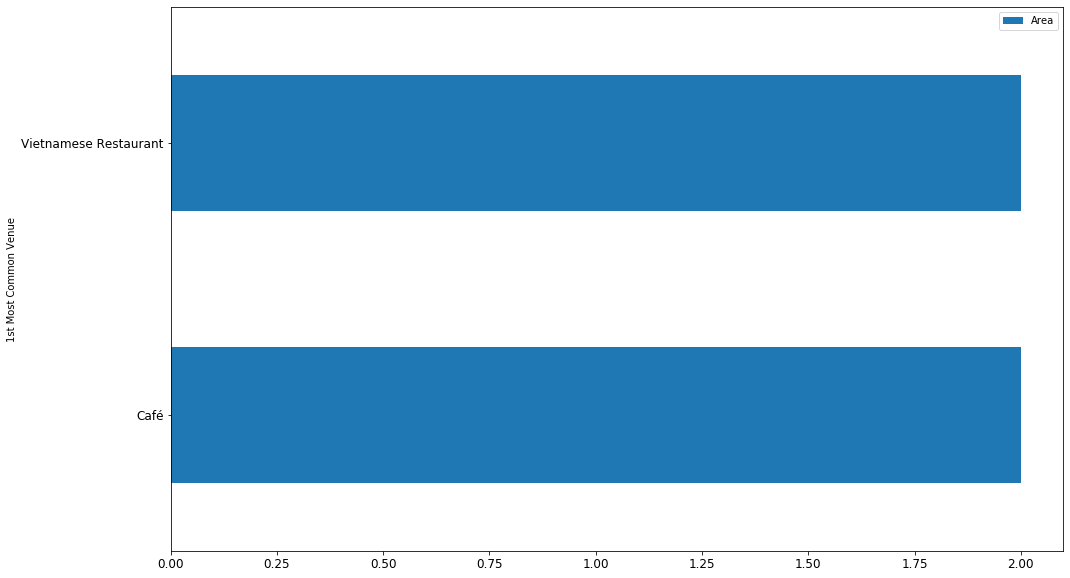

In [54]:
cluster_7 = show_cluster_inf(hcmc_venues_merged, 6, 5)

In [55]:
cluster_7

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
8,"Phường Nguyễn Cư Trinh, Quận 1",6.0,Vietnamese Restaurant,Café,Seafood Restaurant,Dessert Shop,Bookstore,Hotel,Japanese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Bar,Convenience Store,Fast Food Restaurant,Restaurant,Spa,Hotpot Restaurant,Snack Place,Multiplex,Noodle House,Ice Cream Shop
9,"Phường Cầu Kho, Quận 1",6.0,Café,Vietnamese Restaurant,Asian Restaurant,Dessert Shop,Hotpot Restaurant,Restaurant,Convenience Store,Bookstore,Food,Seafood Restaurant,Snack Place,Spa,BBQ Joint,Bakery,Gym / Fitness Center,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Fast Food Restaurant,Bar
114,"Phường 2, Quận Phú Nhuận",6.0,Café,Vietnamese Restaurant,Fast Food Restaurant,Asian Restaurant,Japanese Restaurant,Food,Restaurant,Korean Restaurant,Supermarket,Spa,Ice Cream Shop,Vegetarian / Vegan Restaurant,Karaoke Bar,Steakhouse,Hotpot Restaurant,Pizza Place,Snack Place,Chinese Restaurant,BBQ Joint,Bakery
145,"Phường 3, Quận 3",6.0,Vietnamese Restaurant,Café,Hotel,Bakery,Dessert Shop,Asian Restaurant,Snack Place,Market,Chinese Restaurant,Convenience Store,Food,Hotpot Restaurant,Korean Restaurant,Spa,Japanese Restaurant,Noodle House,Pizza Place,BBQ Joint,Sushi Restaurant,Bar


###### Cluster 8

Number of Area in the cluster: 1


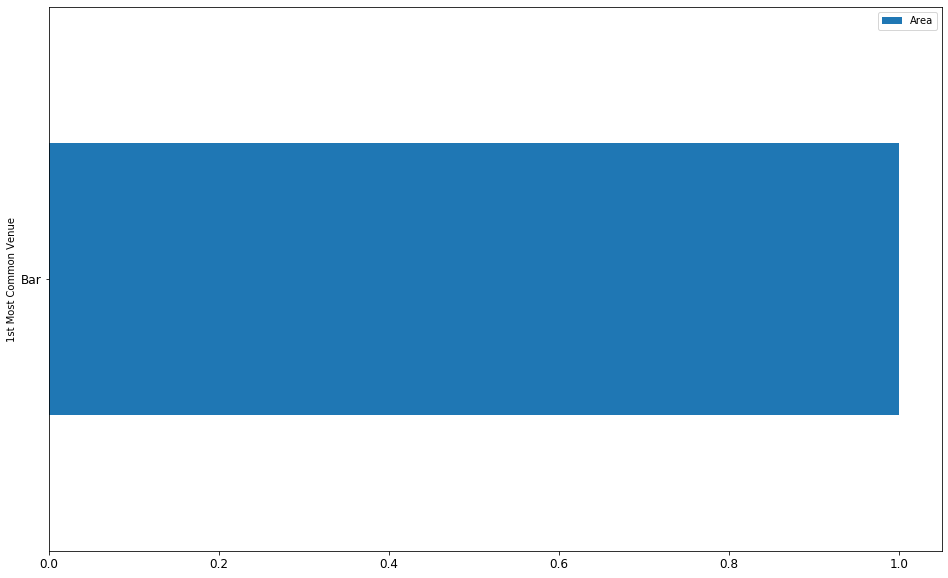

In [56]:
cluster_8 = show_cluster_inf(hcmc_venues_merged, 7, 5)

In [57]:
cluster_8

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
2,"Phường Bến Nghé, Quận 1",7.0,Bar,Hotel,Café,Spa,Vietnamese Restaurant,Restaurant,Noodle House,BBQ Joint,Convenience Store,Dessert Shop,Gym / Fitness Center,Asian Restaurant,Steakhouse,Pizza Place,Multiplex,Seafood Restaurant,Sushi Restaurant,Bakery,Supermarket,Bookstore


###### Cluster 9

Number of Area in the cluster: 11


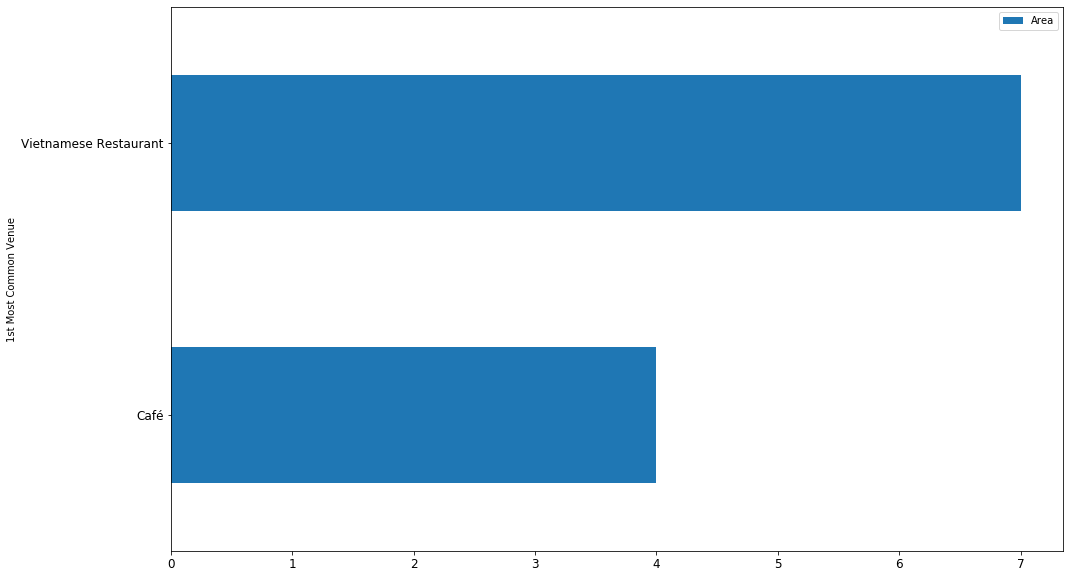

In [58]:
cluster_9 = show_cluster_inf(hcmc_venues_merged, 8, 5)

In [59]:
cluster_9

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,"Phường Tân Định, Quận 1",8.0,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Breakfast Spot,Asian Restaurant,Spa,Food,Bar,Market,Korean Restaurant,Karaoke Bar,Snack Place,BBQ Joint,Bakery,Bookstore,Sushi Restaurant,Supermarket,Chinese Restaurant,Convenience Store,Dessert Shop
78,"Phường 21, Quận Bình Thạnh",8.0,Café,Vietnamese Restaurant,Fast Food Restaurant,Restaurant,Convenience Store,Food,Korean Restaurant,Park,Asian Restaurant,Pizza Place,Seafood Restaurant,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Supermarket,Dessert Shop
80,"Phường 19, Quận Bình Thạnh",8.0,Vietnamese Restaurant,Café,Asian Restaurant,Japanese Restaurant,Food,Bar,Restaurant,Park,Sushi Restaurant,Chinese Restaurant,Korean Restaurant,Gym / Fitness Center,BBQ Joint,Bakery,Bookstore,Breakfast Spot,Convenience Store,Dessert Shop,Fast Food Restaurant,Supermarket
82,"Phường 2, Quận Tân Bình",8.0,Vietnamese Restaurant,Café,Korean Restaurant,Hotel,Japanese Restaurant,Seafood Restaurant,Pizza Place,Spa,Gym / Fitness Center,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food
83,"Phường 4, Quận Tân Bình",8.0,Vietnamese Restaurant,Café,Seafood Restaurant,Fast Food Restaurant,Korean Restaurant,Karaoke Bar,Pizza Place,Asian Restaurant,Snack Place,Restaurant,Food,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Convenience Store,Dessert Shop
111,"Phường 7, Quận Phú Nhuận",8.0,Café,Vietnamese Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Food,Hotpot Restaurant,Ice Cream Shop,Karaoke Bar,Japanese Restaurant,Asian Restaurant,Supermarket,Restaurant,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Chinese Restaurant
139,"Phường 13, Quận 3",8.0,Vietnamese Restaurant,Café,Restaurant,Bookstore,Breakfast Spot,Fast Food Restaurant,Hotel,Korean Restaurant,Asian Restaurant,Seafood Restaurant,Pizza Place,Spa,BBQ Joint,Bakery,Bar,Sushi Restaurant,Supermarket,Steakhouse,Chinese Restaurant,Convenience Store
141,"Phường 9, Quận 3",8.0,Vietnamese Restaurant,Café,Seafood Restaurant,Korean Restaurant,BBQ Joint,Bar,Bookstore,Breakfast Spot,Hotel,Asian Restaurant,Park,Fast Food Restaurant,Sushi Restaurant,Bakery,Supermarket,Steakhouse,Spa,Snack Place,Chinese Restaurant,Convenience Store
151,"Phường 12, Quận 10",8.0,Café,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Steakhouse,Spa,Korean Restaurant,Gym / Fitness Center,Bakery,Bar,Bookstore,Breakfast Spot,Hotel,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,BBQ Joint,Japanese Restaurant,Hotpot Restaurant
152,"Phường 11, Quận 10",8.0,Vietnamese Restaurant,Café,Korean Restaurant,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Japanese Restaurant,Spa,Snack Place,Supermarket,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food


###### Cluster 10

Number of Area in the cluster: 17


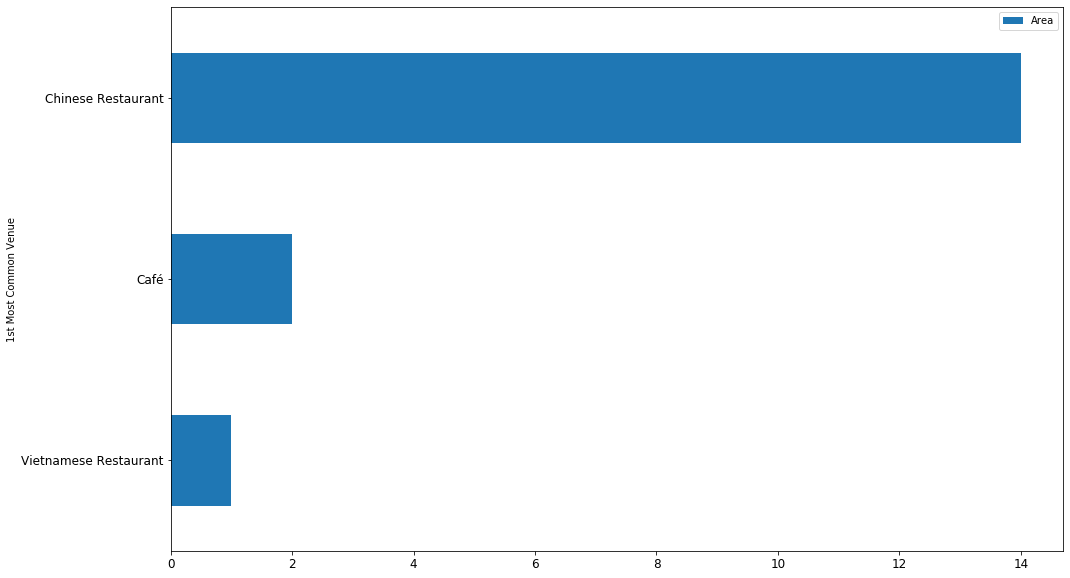

In [60]:
cluster_10 = show_cluster_inf(hcmc_venues_merged, 9, 5)

In [61]:
cluster_10

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
172,"Phường 12, Quận 11",9.0,Chinese Restaurant,Seafood Restaurant,Café,Vietnamese Restaurant,Asian Restaurant,Spa,Snack Place,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Supermarket,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel
174,"Phường 6, Quận 11",9.0,Chinese Restaurant,Asian Restaurant,Seafood Restaurant,Hotel,Gym / Fitness Center,Food,Fast Food Restaurant,Dessert Shop,Convenience Store,Café,Ice Cream Shop,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotpot Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
175,"Phường 4, Quận 11",9.0,Chinese Restaurant,Café,Asian Restaurant,Seafood Restaurant,Restaurant,Bookstore,Breakfast Spot,Bar,Hotpot Restaurant,Bakery,BBQ Joint,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Vietnamese Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant
178,"Phường 16, Quận 11",9.0,Chinese Restaurant,Asian Restaurant,Ice Cream Shop,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Café,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant
196,"Phường 3, Quận 5",9.0,Vietnamese Restaurant,Chinese Restaurant,Noodle House,Food,Asian Restaurant,Hotel,Breakfast Spot,Café,Karaoke Bar,Gym / Fitness Center,BBQ Joint,Bakery,Bar,Bookstore,Sushi Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Supermarket,Spa
197,"Phường 12, Quận 5",9.0,Chinese Restaurant,Café,Vietnamese Restaurant,Multiplex,Dessert Shop,Fast Food Restaurant,Gym / Fitness Center,Asian Restaurant,Seafood Restaurant,Supermarket,Restaurant,Food,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Convenience Store,Steakhouse
198,"Phường 2, Quận 5",9.0,Café,Chinese Restaurant,Vietnamese Restaurant,Noodle House,Food,Asian Restaurant,Hotel,Karaoke Bar,Seafood Restaurant,Steakhouse,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Supermarket,Convenience Store,Dessert Shop,Fast Food Restaurant
199,"Phường 8, Quận 5",9.0,Chinese Restaurant,Café,Vietnamese Restaurant,Noodle House,Park,Dessert Shop,Hotel,Market,Asian Restaurant,Seafood Restaurant,Pizza Place,Fast Food Restaurant,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Supermarket,Convenience Store
200,"Phường 15, Quận 5",9.0,Chinese Restaurant,Café,Seafood Restaurant,Multiplex,Restaurant,Asian Restaurant,Breakfast Spot,Bookstore,Bar,Hotpot Restaurant,Bakery,Convenience Store,BBQ Joint,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel,Vietnamese Restaurant,Ice Cream Shop
201,"Phường 7, Quận 5",9.0,Chinese Restaurant,Vietnamese Restaurant,Noodle House,Market,Breakfast Spot,Café,Dessert Shop,Hotel,Vegetarian / Vegan Restaurant,Asian Restaurant,Park,Fast Food Restaurant,BBQ Joint,Bakery,Bar,Bookstore,Sushi Restaurant,Supermarket,Steakhouse,Convenience Store


###### Cluster 11

Number of Area in the cluster: 8


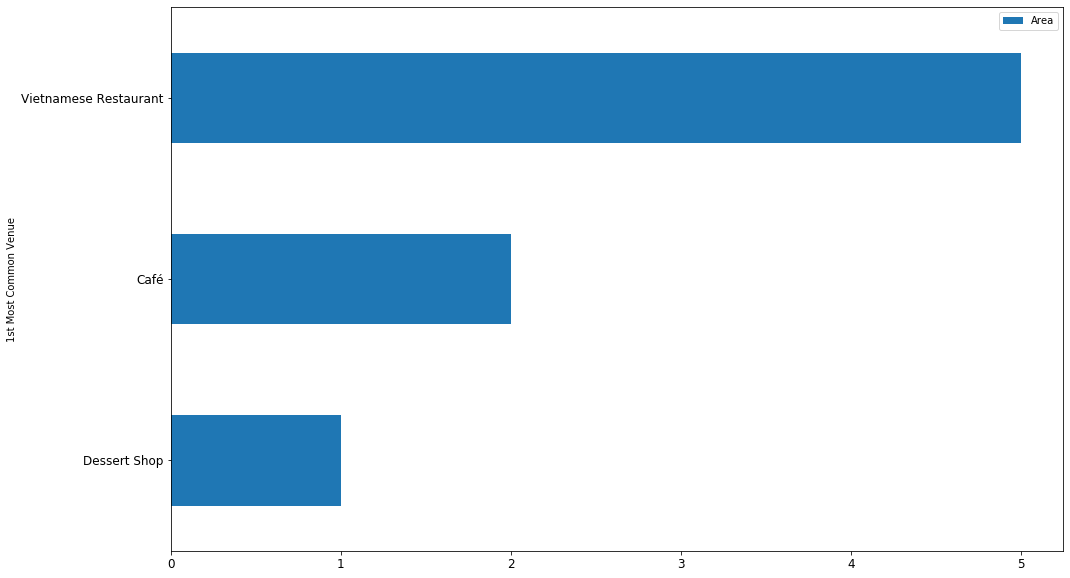

In [62]:
cluster_11 = show_cluster_inf(hcmc_venues_merged, 10, 5)

In [63]:
cluster_11

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
4,"Phường Nguyễn Thái Bình, Quận 1",10.0,Vietnamese Restaurant,Bar,Restaurant,BBQ Joint,Café,Fast Food Restaurant,Hotel,Ice Cream Shop,Market,Dessert Shop,Food,Japanese Restaurant,Spa,Multiplex,Sushi Restaurant,Bakery,Supermarket,Bookstore,Breakfast Spot,Steakhouse
6,"Phường Cầu Ông Lãnh, Quận 1",10.0,Vietnamese Restaurant,Café,Hotel,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Restaurant,BBQ Joint,Dessert Shop,Food,Ice Cream Shop,Japanese Restaurant,Noodle House,Multiplex,Sushi Restaurant,Bakery,Bar,Bookstore,Breakfast Spot,Supermarket,Chinese Restaurant
154,"Phường 9, Quận 10",10.0,Vietnamese Restaurant,Café,Ice Cream Shop,Dessert Shop,Sushi Restaurant,Restaurant,Karaoke Bar,Market,Hotpot Restaurant,Bookstore,Gym / Fitness Center,BBQ Joint,Convenience Store,Breakfast Spot,Fast Food Restaurant,Bar,Food,Bakery,Chinese Restaurant,Japanese Restaurant
156,"Phường 8, Quận 10",10.0,Vietnamese Restaurant,Ice Cream Shop,Fast Food Restaurant,Café,Dessert Shop,Asian Restaurant,Restaurant,BBQ Joint,Noodle House,Market,Snack Place,Food,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Convenience Store,Supermarket
158,"Phường 4, Quận 10",10.0,Vietnamese Restaurant,Ice Cream Shop,Dessert Shop,Seafood Restaurant,Market,Noodle House,Restaurant,Café,Breakfast Spot,Hotel,Chinese Restaurant,Bookstore,Convenience Store,Bar,Bakery,Fast Food Restaurant,Food,BBQ Joint,Gym / Fitness Center,Japanese Restaurant
160,"Phường 5, Quận 10",10.0,Café,Dessert Shop,Vietnamese Restaurant,Restaurant,BBQ Joint,Ice Cream Shop,Noodle House,Asian Restaurant,Seafood Restaurant,Food,Sushi Restaurant,Bakery,Bar,Bookstore,Breakfast Spot,Supermarket,Chinese Restaurant,Convenience Store,Steakhouse,Fast Food Restaurant
162,"Phường 3, Quận 10",10.0,Dessert Shop,Noodle House,Vietnamese Restaurant,Seafood Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Restaurant,Café,Hotpot Restaurant,Breakfast Spot,Gym / Fitness Center,Chinese Restaurant,Bookstore,Convenience Store,Bar,Fast Food Restaurant,Food,Bakery,BBQ Joint,Japanese Restaurant
195,"Phường 9, Quận 5",10.0,Café,Vietnamese Restaurant,Noodle House,Chinese Restaurant,Bakery,Bar,Dessert Shop,Hotel,Ice Cream Shop,Vegetarian / Vegan Restaurant,Market,Asian Restaurant,Seafood Restaurant,Multiplex,Snack Place,BBQ Joint,Sushi Restaurant,Supermarket,Bookstore,Breakfast Spot


###### Cluster 12

Number of Area in the cluster: 1


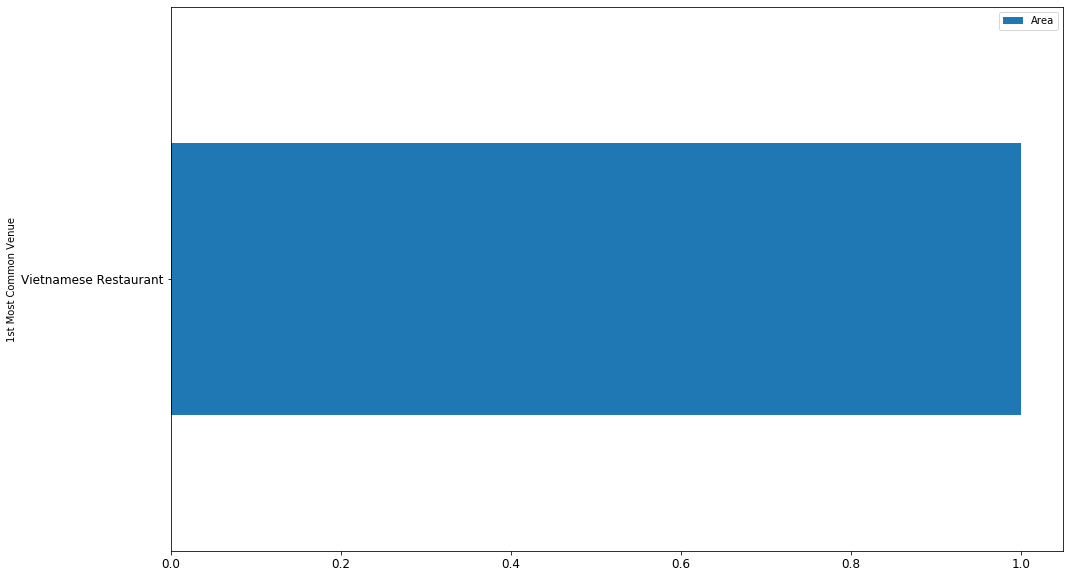

In [64]:
cluster_12 = show_cluster_inf(hcmc_venues_merged, 11, 5)

In [65]:
cluster_12

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1,"Phường Đa Kao, Quận 1",11.0,Vietnamese Restaurant,Café,Japanese Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Breakfast Spot,BBQ Joint,Restaurant,Bakery,Fast Food Restaurant,Sushi Restaurant,Gym / Fitness Center,Hotel,Steakhouse,Ice Cream Shop,Asian Restaurant,Chinese Restaurant,Bar,Noodle House,Park


###### Cluster 13

Number of Area in the cluster: 11


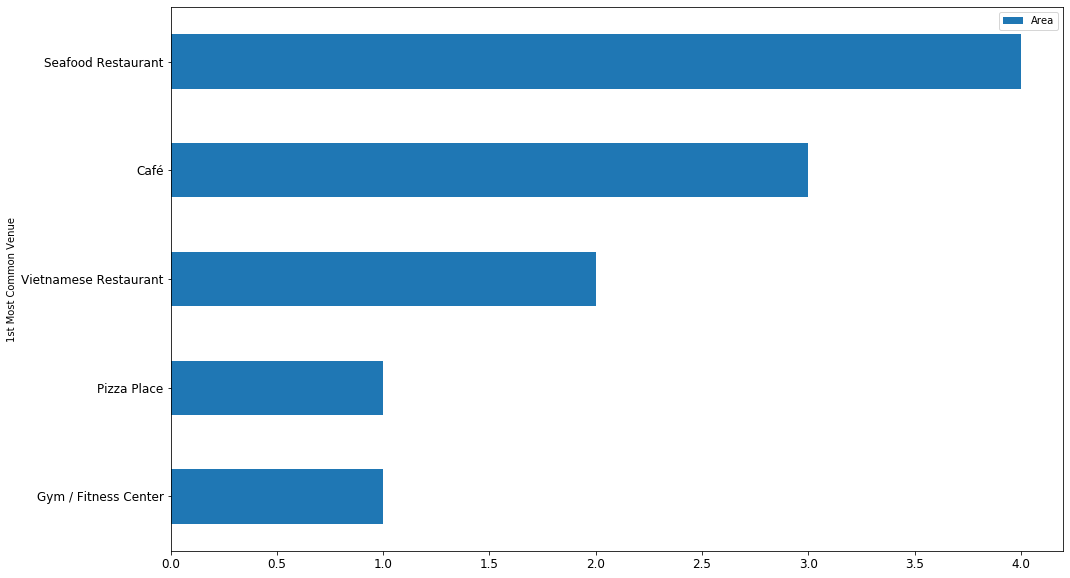

In [68]:
cluster_13 = show_cluster_inf(hcmc_venues_merged, 12, 5)

In [69]:
cluster_13

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
79,"Phường 22, Quận Bình Thạnh",12.0,Gym / Fitness Center,Café,Bakery,Convenience Store,Fast Food Restaurant,Restaurant,Multiplex,Park,Vietnamese Restaurant,Food,Dessert Shop,Chinese Restaurant,Hotpot Restaurant,Breakfast Spot,Bookstore,Bar,BBQ Joint,Hotel,Japanese Restaurant,Ice Cream Shop
112,"Phường 3, Quận Phú Nhuận",12.0,Café,Vietnamese Restaurant,Snack Place,BBQ Joint,Gym / Fitness Center,Pizza Place,Asian Restaurant,Seafood Restaurant,Restaurant,Sushi Restaurant,Bakery,Bar,Bookstore,Breakfast Spot,Supermarket,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food
142,"Phường 10, Quận 3",12.0,Vietnamese Restaurant,Seafood Restaurant,Café,BBQ Joint,Gym / Fitness Center,Snack Place,Restaurant,Convenience Store,Food,Fast Food Restaurant,Dessert Shop,Breakfast Spot,Chinese Restaurant,Hotpot Restaurant,Bookstore,Bar,Bakery,Hotel,Japanese Restaurant,Ice Cream Shop
163,"Phường 15, Quận 11",12.0,Vietnamese Restaurant,Café,Seafood Restaurant,Gym / Fitness Center,Fast Food Restaurant,Market,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Hotpot Restaurant,Chinese Restaurant,Convenience Store,Dessert Shop,Food,Hotel,Japanese Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant
169,"Phường 13, Quận 11",12.0,Café,Seafood Restaurant,Chinese Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Gym / Fitness Center,Bar,Bookstore,Breakfast Spot,Bakery,Ice Cream Shop,BBQ Joint,Convenience Store,Dessert Shop,Food,Hotel,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
181,"Phường 9, Quận 4",12.0,Seafood Restaurant,Café,Food,Restaurant,Vietnamese Restaurant,Market,BBQ Joint,Fast Food Restaurant,Gym / Fitness Center,Hotel,Hotpot Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Noodle House,Snack Place,Multiplex,Convenience Store,Sushi Restaurant,Bakery,Bar
182,"Phường 6, Quận 4",12.0,Seafood Restaurant,Café,Vietnamese Restaurant,BBQ Joint,Gym / Fitness Center,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Market,Noodle House,Hotel,Snack Place,Bakery,Breakfast Spot,Convenience Store,Bookstore,Dessert Shop,Bar,Food,Chinese Restaurant
183,"Phường 8, Quận 4",12.0,Café,Seafood Restaurant,Bakery,Vietnamese Restaurant,Market,Dessert Shop,Fast Food Restaurant,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Korean Restaurant,Japanese Restaurant,Snack Place,Noodle House,Steakhouse,BBQ Joint,Sushi Restaurant,Bar,Bookstore,Breakfast Spot,Supermarket
184,"Phường 10, Quận 4",12.0,Seafood Restaurant,Café,Vietnamese Restaurant,Noodle House,Bakery,Dessert Shop,Food,Market,Japanese Restaurant,Asian Restaurant,Snack Place,Fast Food Restaurant,BBQ Joint,Sushi Restaurant,Bar,Bookstore,Breakfast Spot,Supermarket,Chinese Restaurant,Convenience Store
224,"Phường 2, Quận 8",12.0,Seafood Restaurant,Pizza Place,Gym / Fitness Center,Fast Food Restaurant,Market,Chinese Restaurant,Food,Dessert Shop,Convenience Store,Vietnamese Restaurant,Hotpot Restaurant,Café,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotel,Japanese Restaurant,Ice Cream Shop


###### Cluster 14

Number of Area in the cluster: 15


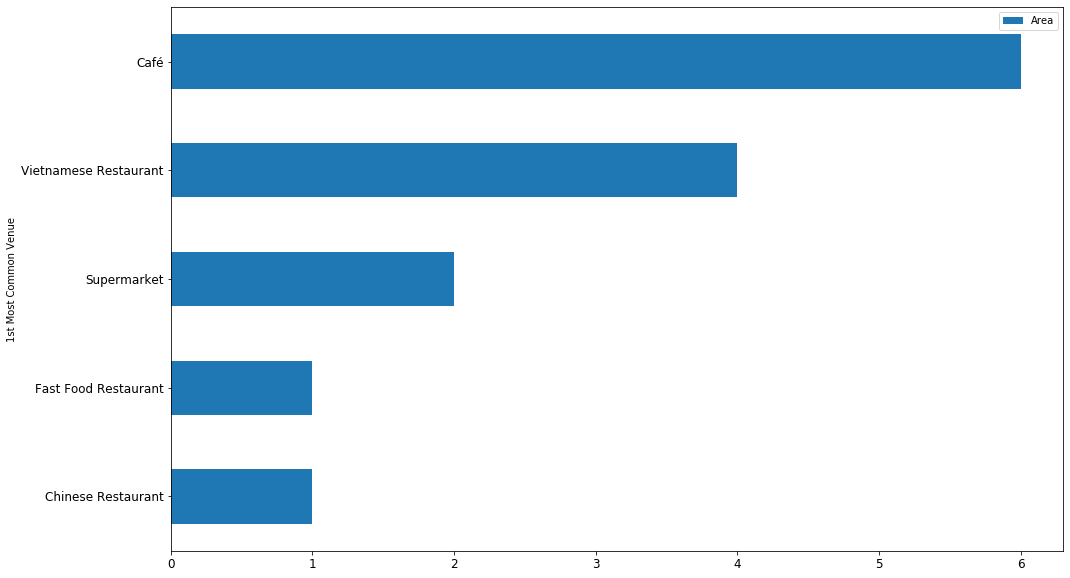

In [70]:
cluster_14 = show_cluster_inf(hcmc_venues_merged, 13, 5)

In [71]:
cluster_14

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
12,"Phường Hiệp Thành, Quận 12",13.0,Vietnamese Restaurant,Supermarket,Market,Chinese Restaurant,Gym / Fitness Center,Food,Fast Food Restaurant,Dessert Shop,Convenience Store,Café,Hotpot Restaurant,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotel,Japanese Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant
53,"Phường 10, Quận Gò Vấp",13.0,Vietnamese Restaurant,Multiplex,Fast Food Restaurant,Café,Supermarket,Bakery,Bar,Bookstore,Breakfast Spot,Hotpot Restaurant,Chinese Restaurant,Convenience Store,Dessert Shop,BBQ Joint,Food,Gym / Fitness Center,Hotel,Japanese Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant
55,"Phường 7, Quận Gò Vấp",13.0,Supermarket,Vietnamese Restaurant,Convenience Store,Café,Asian Restaurant,Spa,Snack Place,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Sushi Restaurant,Chinese Restaurant,Steakhouse,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Hotel
74,"Phường 2, Quận Bình Thạnh",13.0,Supermarket,Fast Food Restaurant,Market,Seafood Restaurant,Convenience Store,Vietnamese Restaurant,Chinese Restaurant,Gym / Fitness Center,Food,Dessert Shop,Café,Hotpot Restaurant,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotel,Japanese Restaurant,Ice Cream Shop
75,"Phường 1, Quận Bình Thạnh",13.0,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Market,Convenience Store,Café,Supermarket,BBQ Joint,Bookstore,Bar,Breakfast Spot,Hotpot Restaurant,Chinese Restaurant,Bakery,Dessert Shop,Food,Gym / Fitness Center,Hotel,Vietnamese Restaurant,Ice Cream Shop
103,"Phường Phú Thạnh, Quận Tân Phú",13.0,Café,Supermarket,Fast Food Restaurant,Chinese Restaurant,Hotel,Gym / Fitness Center,Food,Dessert Shop,Convenience Store,Vietnamese Restaurant,Ice Cream Shop,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
106,"Phường Hiệp Tân, Quận Tân Phú",13.0,Café,Supermarket,Food,Chinese Restaurant,Hotel,Gym / Fitness Center,Fast Food Restaurant,Dessert Shop,Convenience Store,Vietnamese Restaurant,Ice Cream Shop,Breakfast Spot,Bookstore,Bar,Bakery,BBQ Joint,Hotpot Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
148,"Phường 15, Quận 10",13.0,Café,Vietnamese Restaurant,Seafood Restaurant,Park,Restaurant,Hotpot Restaurant,Supermarket,Bookstore,Bar,Bakery,Hotel,BBQ Joint,Chinese Restaurant,Convenience Store,Dessert Shop,Fast Food Restaurant,Food,Gym / Fitness Center,Breakfast Spot,Japanese Restaurant
149,"Phường 13, Quận 10",13.0,Vietnamese Restaurant,Café,Seafood Restaurant,Fast Food Restaurant,Hotel,Steakhouse,Supermarket,Bakery,Bar,Bookstore,Hotpot Restaurant,Chinese Restaurant,Convenience Store,Dessert Shop,BBQ Joint,Food,Gym / Fitness Center,Breakfast Spot,Japanese Restaurant,Ice Cream Shop
159,"Phường 7, Quận 10",13.0,Café,BBQ Joint,Asian Restaurant,Supermarket,Bookstore,Chinese Restaurant,Fast Food Restaurant,Bakery,Bar,Breakfast Spot,Ice Cream Shop,Convenience Store,Dessert Shop,Food,Gym / Fitness Center,Hotel,Hotpot Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Karaoke Bar
